In [8]:
import sys
import os
import pandas as pd
import copy

# Add the parent directory of the 'src' directory to the Python path
sys.path.append(os.path.abspath(os.path.join(os.path.dirname("."), "..")))

In [9]:
from transformers import AutoTokenizer
from benchmark_workload_gen import ToolBenchDataLoader, LoadDistribution

num_workloads = 100
num_requests = 4096
tokenizer = AutoTokenizer.from_pretrained("mistralai/Mistral-7B-v0.1")
dataloader = ToolBenchDataLoader('datasets/G1_workload_updated_input_output_lengths_4096_cropped_to_50.json', num_workloads, num_requests, tokenizer, LoadDistribution.EVEN)

In [10]:
workload = dataloader.generate_workload(k=1.1)

4000


In [11]:
import re
def get_tool(workload_item):
    text = workload_item["text"]
    match = re.search(r"You have access of the following tools:\n1.(.+?): ", text)
    if match:
        tool = match.group(1)
        return tool
get_tool(workload[0]), get_tool(workload[1])

('uncovered_treasure', 'exchange_rate')

In [12]:
import heapq
import time
from collections import defaultdict
from dataclasses import dataclass
from typing import Tuple
from uuid import uuid4  

import torch

class TreeNode:
    def __init__(self):
        self.id = uuid4()  
        self.children = defaultdict(TreeNode)
        self.parent = None
        self.value = None
        self.ref_counter = 0
        self.last_access_time = time.time()
        self.gpu_selections = set()

    @property
    def num_tokens(self):
        return len(self.value)
        
    def __lt__(self, other):
        return self.last_access_time < other.last_access_time
    
    def __eq__(self, other):
        if isinstance(other, TreeNode):
            return self.id == other.id  # Compare nodes based on their unique ID
        return False

    def __hash__(self):
        return hash(self.id)  # Use the unique ID for hashing

def match(key, seq):
    i = 0
    for k, w in zip(key, seq):
        if k != w:
            break
        i += 1
    return i


class RadixCache:
    def __init__(self, disable=False):
        self.reset()
        self.disable = disable

    ##### Public API #####

    def reset(self):
        self.root_node = TreeNode()
        self.root_node.value = []
        self.root_node.ref_counter = 1
        self.evictable_size_ = 0

    def match_prefix_get_gpu_selection(self, key):
        if self.disable:
            return [], self.root_node

        value = []
        current_gpu_selection = self.root_node.gpu_selections
        current_gpu_selection, node = self._match_prefix_helper_gpu_selection(self.root_node, key, value, current_gpu_selection)
        return current_gpu_selection, node

    def _match_prefix_helper_gpu_selection(self, node, key, value, current_gpu_selection):
        node.last_access_time = time.time()
        child: TreeNode
        for c_key, child in node.children.items():
            prefix_len = match(c_key, key)
            if prefix_len != 0:
                text = tokenizer.decode(child.value)
                if child.gpu_selections:
                    current_gpu_selection = child.gpu_selections
                if prefix_len < len(c_key):
                    assert False
                    new_node = self._split_node(c_key, child, prefix_len, new_nodes_created=new_nodes_created)
                    value.append(new_node.value)
                    # last_node[0] = new_node
                else:
                    value.append(child.value)
                    # last_node[0] = child
                    return self._match_prefix_helper_gpu_selection(child, key[prefix_len:], value, current_gpu_selection)
        return current_gpu_selection, node

    def match_prefix_return_str(self, key):
        return "".join(self.match_prefix(key)[0])

    def insert(self, key, value=None, node_map=None, all_modified_nodes=None, depth_limit=0):
        if node_map is None:
            node_map = {}
        if self.disable:
            return len(key)

        if value is None:
            value = [x for x in key]
        modified_nodes = set()
        total_tokens_added = self._insert_helper(
            self.root_node,
            key, 
            value, 
            node_map=node_map, 
            modified_nodes=modified_nodes, 
            depth_limit=depth_limit, 
            current_depth=0
        )

        node: TreeNode
        for node in modified_nodes:
            # Add all parents till parent is none to all_modified_nodes
            while node is not None:
                all_modified_nodes.add(node)
                node = node.parent
        return total_tokens_added

    def pretty_print(self):
        self._print_helper(self.root_node, 0)
        print(f"#tokens: {self.total_size()}")

    def total_size(self):
        return self._total_size_helper(self.root_node)

    def evict(self, num_tokens, evict_callback):
        if self.disable:
            raise RuntimeError()

        leaves = self._collect_leaves()
        heapq.heapify(leaves)

        num_evicted = 0
        while num_evicted < num_tokens and len(leaves):
            x = heapq.heappop(leaves)

            if x == self.root_node:
                break
            if x.ref_counter > 0:
                continue

            num_evicted += evict_callback(x.value)
            self._delete_leaf(x)

            if len(x.parent.children) == 0:
                heapq.heappush(leaves, x.parent)

    def inc_ref_counter(self, node):
        delta = 0
        while node != self.root_node:
            if node.ref_counter == 0:
                self.evictable_size_ -= len(node.value)
                delta -= len(node.value)
            node.ref_counter += 1
            node = node.parent
        return delta

    def dec_ref_counter(self, node):
        delta = 0
        while node != self.root_node:
            if node.ref_counter == 1:
                self.evictable_size_ += len(node.value)
                delta += len(node.value)
            node.ref_counter -= 1
            node = node.parent
        return delta

    def evictable_size(self):
        return self.evictable_size_

    def _split_node(self, key, child, split_len, node_map, depth_limit, current_depth):
        # new_node -> child
        is_initial_code_in_node_map = child in node_map
        if is_initial_code_in_node_map:
            lp_node = node_map[child]

        new_node = TreeNode()
        new_node.gpu_selections = copy.deepcopy(child.gpu_selections)
        new_node.children = {
            key[split_len:]: child
        }
        new_node.parent = child.parent
        new_node.ref_counter = child.ref_counter

        new_node.value = child.value[:split_len]
        child.parent = new_node
        child.value = child.value[split_len:]

        new_node.parent.children[key[:split_len]] = new_node
        del new_node.parent.children[key]

        if is_initial_code_in_node_map and current_depth < depth_limit:
            # NODE Map is updated because splitting the nodes needs to preserve solver state
            node_map[child] = lp_node
            node_map[new_node] = lp_node
            # Potentionally pop the previous entry

        if is_initial_code_in_node_map and current_depth < depth_limit:
            assert child in node_map
            assert new_node in node_map
        return new_node

    def _insert_helper(self, node, key, value, node_map, modified_nodes, depth_limit, current_depth):
        node.last_access_time = time.time()
        node.ref_counter += 1
        for c_key, child in node.children.items():
            prefix_len = match(c_key, key)

            if prefix_len == len(c_key):
                if prefix_len == len(key):
                    child.ref_counter += 1
                    return prefix_len
                else:
                    key = key[prefix_len:]
                    value = value[prefix_len:]
                    return prefix_len + self._insert_helper(child, key, value, node_map=node_map, modified_nodes=modified_nodes, depth_limit=depth_limit, current_depth=current_depth + 1)

            if prefix_len:
                new_node = self._split_node(c_key, child, prefix_len, node_map, depth_limit=depth_limit, current_depth=current_depth + 1)
                modified_nodes.add(new_node)
                modified_nodes.add(child)
                return prefix_len + self._insert_helper(
                    new_node, key[prefix_len:], value[prefix_len:], node_map=node_map, modified_nodes=modified_nodes, depth_limit=depth_limit, current_depth=current_depth + 1
                )

        if len(key):
            new_node = TreeNode()
            new_node.gpu_selections = copy.deepcopy(node.gpu_selections)
            new_node.parent = node
            new_node.value = value
            new_node.ref_counter = 1
            node.children[key] = new_node
            self.evictable_size_ += len(value)
            if current_depth < depth_limit:
                modified_nodes.add(new_node)
        return 0

    def _print_helper(self, node, indent, depth=0):
        if depth == 5:
            return
        for key, child in node.children.items():
            print(" " * indent, len(key), key[:10], f"r={child.ref_counter}")
            self._print_helper(child, indent=indent + 2, depth=depth + 1)
        

    def _delete_leaf(self, node):
        for k, v in node.parent.children.items():
            if v == node:
                break
        del node.parent.children[k]
        self.evictable_size_ -= len(k)

    def _total_size_helper(self, node):
        x = len(node.value)
        for child in node.children.values():
            x += self._total_size_helper(child)
        return x

    def _collect_leaves(self):
        ret_list = []

        def dfs_(cur_node):
            if len(cur_node.children) == 0:
                ret_list.append(cur_node)

            for x in cur_node.children.values():
                dfs_(x)

        dfs_(self.root_node)
        return ret_list


In [20]:
import time
from mip import Model, xsum, BINARY, MINIMIZE, OptimizationStatus, minimize, INTEGER, GUROBI
import random

class LpNode:
    def __init__(self, node_id, num_gpus):
        self.node_id = node_id
        self.variables = [None] * num_gpus  # Will be initialized as binary variables in the model
        self.children_token_cost_at_max_depth = 0 # Issue is that depth_limit will cut off the tokens for children and that will treat it as free
        self.randomly_selected_gpu = None

class LPTreeTraversal:
    def __init__(self, num_gpus):
        self.num_gpus = num_gpus
        self.node_map = {}  # Maps PrefixTreeNode to LpNode
        self.depth_limit = 5
        self.model = Model(sense=MINIMIZE, solver_name=GUROBI)
        self.model.verbose = 1
        self.counter = 0
        self.total_cost_var = None
        self.per_gpu_constraints = []
        self.dynamic_constraints = []  # To keep track of dynamic constraints
        self.iteration_counter = 0 

    def _traverse_tree(self, current_prefix_node: TreeNode, parent_lp_node=None, depth=0, modified_nodes=None):
        if modified_nodes is None:
            modified_nodes = set()
        if current_prefix_node not in modified_nodes:
            return # Skip nodes that have not been modified

        if depth == self.depth_limit:
            assert parent_lp_node is not None
            parent_lp_node.children_token_cost_at_max_depth = self._calculate_children_token_cost(current_prefix_node)
            return
        self.counter += 1
        current_lp_node = LpNode(current_prefix_node.id, self.num_gpus)
        self.node_map[current_prefix_node] = current_lp_node
        # Initialize binary variables for the LP node
        for gpu in range(self.num_gpus):
            current_lp_node.variables[gpu] = self.model.add_var(f"node_{self.counter}_{gpu}",var_type=BINARY)

        # At least one GPU must be allocated for a prefix
        self.model += xsum(current_lp_node.variables) >= 1

        if parent_lp_node:
            # If the child takes a node, then the parent must also take a node
            for gpu in range(self.num_gpus):
                self.model += current_lp_node.variables[gpu] <= parent_lp_node.variables[gpu]

        for child_prefix_node in current_prefix_node.children.values():
            self._traverse_tree(current_prefix_node=child_prefix_node, parent_lp_node=current_lp_node, depth=depth + 1, modified_nodes=modified_nodes)

    def _calculate_children_token_cost(self, node):
        """
        Recursively calculate the total number of tokens for all children of a given node,
        effectively aggregating the tokens for nodes that are beyond the depth limit.
        """
        if node is None:
            return 0
        total_tokens = node.num_tokens
        for child in node.children.values():
            total_tokens += self._calculate_children_token_cost(child)
        return total_tokens

    def add_parent_child_gpu_constraints(self, modified_nodes=None):
        if modified_nodes is None:
            modified_nodes = set()
        for parent_prefix_node, parent_lp_node in self.node_map.items():
            if parent_prefix_node not in modified_nodes:
                continue
            if not parent_prefix_node.children:  # Skip leaf nodes
                continue
            for gpu_index in range(self.num_gpus):
                children_gpu_selections = []
                for child_prefix_node in parent_prefix_node.children.values():
                    if child_prefix_node in self.node_map:
                        child_lp_node = self.node_map[child_prefix_node]
                        children_gpu_selections.append(child_lp_node.variables[gpu_index])
                if children_gpu_selections:
                    children_selections_total = xsum(children_gpu_selections)
                    self.model += parent_lp_node.variables[gpu_index] <= children_selections_total
    
    def traverse_and_optimize(self, prefix_tree_root, existing_cost={}, modified_nodes=None, objective_only=False):
        if modified_nodes is None:
            modified_nodes = set()
        start_time = time.time()

        # self.model.reset()  # Re-initialize the model for a new optimization problem
        # self.model = Model(sense=MINIMIZE, solver_name=GUROBI)

        self.model.verbose = 1
        if self.iteration_counter % 100 == 0:
            self.model = Model(sense=MINIMIZE, solver_name=GUROBI)
            modified_nodes = set()
            self.model.verbose = 1
            self.iteration_counter += 1

        self._traverse_tree(prefix_tree_root, modified_nodes=modified_nodes)  # Set up variables and base constraints
        self.add_parent_child_gpu_constraints(modified_nodes=modified_nodes)  # Add parent-child constraints

        # Objective components: Let's assume we're trying to minimize the total cost adjusted for existing costs
        total_cost = []
        per_gpu_cost = [[] for _ in range(self.num_gpus)]
        initial_solution = []
        total_cost_saved = 0
        for prefix_node, lp_node in self.node_map.items():
            node_costs = existing_cost.get(prefix_node, {})
            # children token cost is to account for depth cutoff
            # depth 3: tool 5, examples
            num_tokens_total = prefix_node.num_tokens + lp_node.children_token_cost_at_max_depth
            for gpu_index, var in enumerate(lp_node.variables):
                previous_gpu_selected = existing_cost.get(prefix_node, {}).get(gpu_index, 0) 
                if previous_gpu_selected:
                    initial_solution.append((var, previous_gpu_selected))
                    total_cost_saved += previous_gpu_selected * num_tokens_total

                total_cost.append(var * num_tokens_total - var * previous_gpu_selected * num_tokens_total)
                per_gpu_cost[gpu_index].append(var * num_tokens_total)

        # for c in self.dynamic_constraints:
        #     self.model.remove(c)
        # self.dynamic_constraints.clear()  # Clear the list after removing from the model

        # Add updated dynamic constraints
        self.max_per_gpu_cost = self.model.add_var(var_type=INTEGER)

        for gpu_cost in per_gpu_cost:
            current_gpu_cost = xsum(gpu_cost)
            constraint = self.model.add_constr(current_gpu_cost <= self.max_per_gpu_cost)
            # self.dynamic_constraints.append(constraint)  # Keep track of this constraint

        # self.per_gpu_constraints = per_gpu_constraints
        self.model.start = initial_solution
        self.model.threads = -1
        # self.model.max_mip_gap = 0.02
        # self.model.max_seconds = 0.2
        setup_time = time.time() - start_time
        solving_time = time.time()
        self.model.objective = minimize(xsum(total_cost) + self.max_per_gpu_cost)
            
        status = self.model.optimize()

        # print(f"max cost per gpu {max_per_gpu_cost.x} {total_cost_var.x}")
        # tokens_per_gpu, load_to_gpu = self.calculate_tokens_per_gpu()
        # print(f"Tokens per GPU: {tokens_per_gpu} {load_to_gpu}")
        # print(f"Objective value: {self.model.objective_value}")

        if status == OptimizationStatus.OPTIMAL:
            pass
            # print('Optimal solution found.')
        elif status == OptimizationStatus.FEASIBLE:
            print('Feasible solution found, but not necessarily optimal.')
        else:
            print('No feasible solution found.')
        print(f"Solving time: {time.time() - solving_time}s Setup Time {setup_time}s Tota")

    def get_exisiting_cost(self):
        existing_cost = {}
        lp_node: LpNode
        for prefix_node, lp_node in self.node_map.items():
            for gpu_id, var in enumerate(lp_node.variables):
                if prefix_node not in existing_cost:
                    existing_cost[prefix_node] = {}
                solver_selection = var and var.x >= 0.99
                random_selection = lp_node.randomly_selected_gpu and lp_node.randomly_selected_gpu == gpu_id
                if solver_selection or random_selection:
                    existing_cost[prefix_node][gpu_id] = 1
                else:
                    existing_cost[prefix_node][gpu_id] = 0
        return existing_cost

    def calculate_tokens_per_gpu(self):
        tokens_per_gpu = {gpu: 0 for gpu in range(self.num_gpus)}  # Reset/initialize
        load_to_gpu = {gpu: 0 for gpu in range(self.num_gpus)}
        lp_node:LpNode
        for prefix_node, lp_node in self.node_map.items():
            for i, var in enumerate(lp_node.variables):
                solved_var = var.x if var.x >= 0.99 else 0
                if solved_var:  # If GPU i is selected by this node, using .x for variable value in MIP
                    tokens_per_gpu[i] += prefix_node.num_tokens  # Accumulate tokens
                    load_to_gpu[i] += prefix_node.ref_counter
        return tokens_per_gpu, load_to_gpu


    def pretty_print(self, prefix_node):
        # This method will call pretty_print_helper and then print additional information
        # Adjustments are mainly in handling variable values using .x in MIP
        self.pretty_print_helper(prefix_node)
        # tokens_per_gpu, load_to_gpu = self.calculate_tokens_per_gpu()
        # print(f"Tokens per GPU: {tokens_per_gpu} {load_to_gpu}")
        # print(f"Objective value: {self.model.objective_value}")

    def pretty_print_helper(self, prefix_node, indent="", depth=0):
        if depth == self.depth_limit:
            return
        lp_node = self.node_map.get(prefix_node)
        if lp_node:
            if lp_node.randomly_selected_gpu:
                selected_gpus = [lp_node.randomly_selected_gpu]
            else:
                selected_gpus = [i for i, var in enumerate(lp_node.variables) if var and var.x >= 0.99]  # Adjust threshold as needed, using .x for variable value
            # if lp_node.node_id == 4 or True:

            def get_tool(workload_item):
                text = tokenizer.decode(workload_item)
                if ":" in text:
                    return text.split(":")[0].strip().replace("\n", " ")
                else:
                    return text[:60].strip().replace("\n", "")
            print(f"{indent}Node {lp_node.node_id} (Tokens: {get_tool(prefix_node.value)}, {len(prefix_node.value)}): GPUs {selected_gpus}")
        else:
            print(f"{indent}Node (Prefix: {len(prefix_node.value)}) has no LP Node mapping")

        for child in prefix_node.children.values():
            self.pretty_print_helper(child, indent + "  ", depth=depth + 1)

    def update_nodes_with_solution(self, modified_nodes=None):
        for prefix_node, lp_node in self.node_map.items():
            prefix_node.gpu_selections = set()
            for gpu_id, var in enumerate(lp_node.variables):
                if var.x >= 0.99:
                    prefix_node.gpu_selections.add(gpu_id)

class LPScheduler:
    def __init__(self, num_nodes: int, depth_limit=4, update_interval=5):
        self.num_nodes = num_nodes
        self.tree_cache = RadixCache()
        self.shadow_cache = RadixCache()
        self.lp_tree_traversal = LPTreeTraversal(num_nodes)
        self.lp_tree_traversal.depth_limit = depth_limit
        self.metrics_dict = []
        self.counter = 0
        self.update_interval=update_interval
        self.load = {

        }
        self.modified_nodes = set()

    def runtime_selector(self, text: str=None, request_id: str=None, input_ids=None, ):
        # Tokenize the text
        start_time = time.time()

        node_map = self.lp_tree_traversal.node_map
        self.tree_cache.insert(tuple(input_ids), node_map=node_map, all_modified_nodes=self.modified_nodes, depth_limit=self.lp_tree_traversal.depth_limit)
        if self.counter % self.update_interval == 0:
            existing_cost = self.lp_tree_traversal.get_exisiting_cost()
            self.lp_tree_traversal.traverse_and_optimize(self.tree_cache.root_node, existing_cost=existing_cost, modified_nodes=self.modified_nodes)
            self.lp_tree_traversal.update_nodes_with_solution()
            self.modified_nodes = set()

        self.counter += 1
        gpu_selections, node = self.tree_cache.match_prefix_get_gpu_selection(input_ids)
        # Randomly select a node from gpu selections
        mode = "not_random"
        if len(gpu_selections) == 0 or len(gpu_selections) == self.num_nodes:
            print("Random selection", gpu_selections)
            gpu_selections = set(range(self.num_nodes))
            mode = "random"

        runtime_selected = random.choice(list(gpu_selections))
        self.load[runtime_selected] = self.load.get(runtime_selected, 0) + 1
        self.metrics_dict.append({
            "text": text,
            "rid": request_id,
            "selected_runtime": runtime_selected,
            "overhead": time.time() - start_time,
            "mode": mode
        })
        return runtime_selected

# Example usage (you would need to define the structure of PrefixTreeNode and provide a valid prefix_tree_root):


In [34]:
import random
print(f"Workload length: {len(workload)}")
lp_tree_traversal = LPTreeTraversal(2)
lp_tree_traversal.depth_limit = 4
runtime_selected = []
texts = ["1 sentence. A B C D", "3 sentence. A B C D", "4 sentencee. A B C D", "2 sentence. A B C D", "1 sentence. A B C D example 1", "1 sentence example 2", "2 sentence. A B C D E"]
input_ids = [tokenizer.encode(text) for text in texts]
cache = RadixCache()
modified_nodes = set()
for i in range(len(texts)):
    print(f"Request {i}")
    node_map = lp_tree_traversal.node_map
    cache.insert(tuple(input_ids[i]), node_map=node_map, all_modified_nodes=modified_nodes, depth_limit=lp_tree_traversal.depth_limit)
    existing_cost = lp_tree_traversal.get_exisiting_cost()
    runtime = lp_tree_traversal.traverse_and_optimize(cache.root_node, existing_cost=existing_cost, modified_nodes=modified_nodes)
    tokens_per_gpu, load_to_gpu = lp_tree_traversal.calculate_tokens_per_gpu()
    print(f"Tokens per GPU: {tokens_per_gpu} {load_to_gpu}")
    lp_tree_traversal.update_nodes_with_solution()
    lp_tree_traversal.pretty_print(cache.root_node)
    modified_nodes = set()
# scheduler = LPScheduler(2)
# for i in range(4):
#     print(f"Request {i}")
#     cache.insert(tuple(input_ids[i]))
#     runtime_selected = scheduler.runtime_selector(text=texts[i], request_id=i, input_ids=input_ids[i])
#     print(texts[i],runtime_selected)

# Solving time: 0.002257823944091797s Setup Time 0.0004932880401611328s Tota
# Tokens per GPU: {0: 15, 1: 23} {0: 2, 1: 25}
# Node 788cf5fc-18d7-457f-b0dc-a539b3893317 (Tokens: , 0): GPUs [1]
#   Node 92f40a69-c4a6-475c-a769-8529f6b643ce (Tokens: <s>, 2): GPUs [1]
#     Node 73e2bc85-89f6-47df-94c5-4bb8c8781b94 (Tokens: 3 sentence. A B C D, 7): GPUs [0]
#     Node cb5f9bae-8c79-4ee5-9dee-148cd319ada1 (Tokens: 4 sentencee. A B C D, 8): GPUs [0]
#     Node e20b8de9-3418-4a84-ae36-0c198c0fbd69 (Tokens: 2 sentence. A B C D, 7): GPUs [1]
#       Node 7dec93f3-386c-4acd-86e2-74bc2c40793d (Tokens: E, 1): GPUs [1]
#     Node 8e52ba77-a8d1-4234-8890-ffb2bc6b3d3c (Tokens: 1 sentence, 2): GPUs [1]
#       Node 0111080d-33d8-405a-8c77-372f56941c75 (Tokens: . A B C D, 5): GPUs [1]
#       Node 8f1e14f3-6788-4175-948c-526a2139ccc0 (Tokens: example 2, 3): GPUs [1]

# Tokens per GPU: {0: 21, 1: 17} {0: 8, 1: 19}
# Node 9e2c608d-8982-4153-921a-0cb14cc4ffb3 (Tokens: , 0): GPUs [1]
#   Node 0fdfa435-4e9c-452f-916d-180e41f28f8a (Tokens: <s>, 2): GPUs [1]
#     Node 9fa7b67f-81cd-411e-ac4c-4fe07b9ee6f6 (Tokens: 3 sentence. A B C D, 7): GPUs [1]
#     Node 1b8c920a-4bc2-4e71-8127-a2a19360c86a (Tokens: 4 sentencee. A B C D, 8): GPUs [0]
#     Node c34b4187-ba1d-459b-a997-4523aba3aa41 (Tokens: 2 sentence. A B C D, 7): GPUs [1]
#       Node b6636d63-159d-45b8-8bbf-defc09d5ff82 (Tokens: E, 1): GPUs [1]
#     Node 9bafe84c-a081-4449-822a-b0a98cf6e3cf (Tokens: 1 sentence, 2): GPUs [0]
#       Node 6270be96-f957-4419-837a-34f50c4074f0 (Tokens: . A B C D, 5): GPUs [0]
#       Node bf282cc8-7560-4967-9248-d492630c9da4 (Tokens: example 2, 3): GPUs [0]



Workload length: 4096
Set parameter Username
Request 0
Set parameter Username
Solving time: 0.0002665519714355469s Setup Time 0.0043070316314697266s Tota
Tokens per GPU: {0: 0, 1: 0} {0: 0, 1: 0}
Node (Prefix: 0) has no LP Node mapping
  Node (Prefix: 9) has no LP Node mapping
Request 1
Solving time: 0.006677865982055664s Setup Time 0.00035858154296875s Tota
Tokens per GPU: {0: 9, 1: 9} {0: 6, 1: 6}
Node 0083b1a0-f113-4239-b86e-26f28efbfbdd (Tokens: , 0): GPUs [0, 1]
  Node 84ca3c96-2745-4f8d-a3dc-7ab2cbbfbb8a (Tokens: <s>, 2): GPUs [0, 1]
    Node c003fe70-8b60-4ed7-a5d3-66fb0a48acf9 (Tokens: 1 sentence. A B C D, 7): GPUs [0]
    Node 416fc22f-e68c-4ce9-ad0b-16cee50e631d (Tokens: 3 sentence. A B C D, 7): GPUs [1]
Request 2
Solving time: 0.0068607330322265625s Setup Time 0.00034117698669433594s Tota
Tokens per GPU: {0: 17, 1: 9} {0: 9, 1: 8}
Node 0083b1a0-f113-4239-b86e-26f28efbfbdd (Tokens: , 0): GPUs [0, 1]
  Node 84ca3c96-2745-4f8d-a3dc-7ab2cbbfbb8a (Tokens: <s>, 2): GPUs [0, 1]
   

In [22]:
import random
print(f"Workload length: {len(workload)}")
scheduler = LPScheduler(2, depth_limit=3, update_interval=4)
runtime_selected = []

# input_ids = [tokenizer.encode(text) for text in texts]
# for i in range(len(texts)):
#     runtime = scheduler.runtime_selector(input_ids=input_ids[i], text=texts[i])
#     scheduler.lp_tree_traversal.pretty_print(scheduler.tree_cache.root_node)
#     runtime_selected.append(runtime)
for i in workload[:50]:
    runtime = scheduler.runtime_selector(input_ids=i["input_ids"], text=i["text"])
    # scheduler.lp_tree_traversal.pretty_print(scheduler.tree_cache.root_node)
    runtime_selected.append(runtime)

print(pd.DataFrame(scheduler.metrics_dict))
# Write metrics dict to json
import json
with open("metrics_lp_scheduler_2_200.json", "w") as f:
    json.dump(scheduler.metrics_dict, f)


Workload length: 4000
Set parameter Username
Set parameter Username
Solving time: 0.00019121170043945312s Setup Time 0.0036056041717529297s Tota
Random selection set()
Random selection set()
Random selection set()
Random selection set()
Solving time: 0.012043237686157227s Setup Time 0.0005278587341308594s Tota
Random selection {0, 1}
Random selection {0, 1}
Random selection {0, 1}
Solving time: 0.014904975891113281s Setup Time 0.00054931640625s Tota
Random selection {0, 1}
Random selection {0, 1}
Random selection {0, 1}
Solving time: 0.015493154525756836s Setup Time 0.0006043910980224609s Tota
Random selection {0, 1}
Random selection {0, 1}
Random selection {0, 1}
Solving time: 0.0157167911529541s Setup Time 0.0006780624389648438s Tota
Random selection {0, 1}
Random selection {0, 1}
Solving time: 0.009476184844970703s Setup Time 0.0014085769653320312s Tota
Random selection {0, 1}
Random selection {0, 1}
Random selection {0, 1}
Solving time: 0.011538267135620117s Setup Time 0.0008547306

In [23]:
workload[0]

{'text': 'System: You are AutoGPT, you can use many tools(functions) to do the following task.\nFirst I will give you the task description, and your task start.\nAt each step, you need to give your thought to analyze the status now and what to do next, with a function call to actually excute your step.\nAfter the call, you will get the call result, and you are now in a new state.\nThen you will analyze your status now, then decide what to do next...\nAfter many (Thought-call) pairs, you finally perform the task, then you can give your finial answer.\nRemember: \n1.the state change is irreversible, you can\'t go back to one of the former state, if you want to restart the task, say "I give up and restart".\n2.All the thought is short, at most in 5 sentence.\n3.You can do more then one trys, so if your plan is to continusly try some conditions, you can do one of the conditions per try.\nLet\'s Begin!\nTask description: You should use functions to help handle the real time user querys. Rem

# Debug Random workload

In [24]:
from transformers import AutoTokenizer
from benchmark_workload_gen import RandomDataLoader

num_workloads = 100
num_requests = 4096
tokenizer = AutoTokenizer.from_pretrained("mistralai/Mistral-7B-v0.1")
dataloader = RandomDataLoader(4, total_num_requests=num_requests, tokenizer=tokenizer, load_dist=LoadDistribution.EVEN, random_workload_path="datasets/ShareGPT_V3_unfiltered_cleaned_split.json")

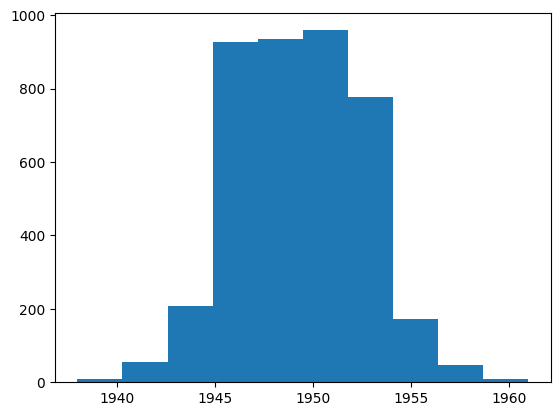

In [25]:
workload = dataloader.generate_workload(k=1.1)

In [26]:
import random
print(f"Workload length: {len(workload)}")
scheduler = LPScheduler(2, depth_limit=3, update_interval=1)
runtime_selected = []

for i in workload[:200]:
    runtime = scheduler.runtime_selector(input_ids=i["input_ids"], text=i["text"])
    # scheduler.lp_tree_traversal.pretty_print(scheduler.tree_cache.root_node)
    runtime_selected.append(runtime)

print(pd.DataFrame(scheduler.metrics_dict))
# Write metrics dict to json
import json
with open("metrics_lp_scheduler_2_200.json", "w") as f:
    json.dump(scheduler.metrics_dict, f)


Workload length: 4096
Set parameter Username
Set parameter Username
Solving time: 0.00020933151245117188s Setup Time 0.005006551742553711s Tota
Random selection set()
Solving time: 0.0062825679779052734s Setup Time 0.0003287792205810547s Tota
Solving time: 0.002953767776489258s Setup Time 0.00033402442932128906s Tota
Solving time: 0.002825498580932617s Setup Time 0.0003762245178222656s Tota
Solving time: 0.0046863555908203125s Setup Time 0.0003204345703125s Tota
Solving time: 0.005129098892211914s Setup Time 0.0003428459167480469s Tota
Solving time: 0.0059664249420166016s Setup Time 0.0006530284881591797s Tota
Solving time: 0.005242586135864258s Setup Time 0.00035691261291503906s Tota
Solving time: 0.005185842514038086s Setup Time 0.0003924369812011719s Tota
Solving time: 0.005179643630981445s Setup Time 0.0003676414489746094s Tota
Solving time: 0.005583524703979492s Setup Time 0.0003657341003417969s Tota
Solving time: 0.0056781768798828125s Setup Time 0.00037288665771484375s Tota
Solv

In [27]:
import re 
df = pd.DataFrame(scheduler.metrics_dict)
def get_tool(x):
    text = x
    match = re.search(r"You have access of the following tools:\n1.(.+?): ", text)
    if match:
        tool = match.group(1)
        return tool
    return text
print(df)
df["text"] = df["text"].map(lambda x: get_tool(x))

df.to_csv("test.csv")

                                                  text   rid  \
0    Workload 2 Solve a question answering task wit...  None   
1    Workload 0 Solve a question answering task wit...  None   
2    Workload 0 Solve a question answering task wit...  None   
3    Workload 0 Solve a question answering task wit...  None   
4    Workload 0 Solve a question answering task wit...  None   
..                                                 ...   ...   
195  Workload 2 Solve a question answering task wit...  None   
196  Workload 3 Solve a question answering task wit...  None   
197  Workload 0 Solve a question answering task wit...  None   
198  Workload 1 Solve a question answering task wit...  None   
199  Workload 2 Solve a question answering task wit...  None   

     selected_runtime  overhead        mode  
0                   0  0.013628      random  
1                   1  0.014920  not_random  
2                   1  0.011791  not_random  
3                   1  0.011301  not_random  
4

In [28]:
df

,text,rid,selected_runtime,overhead,mode
0,Workload 2 Solve a question answering task wit...,None,0,0.013628,random
1,Workload 0 Solve a question answering task wit...,None,1,0.014920,not_random
2,Workload 0 Solve a question answering task wit...,None,1,0.011791,not_random
3,Workload 0 Solve a question answering task wit...,None,1,0.011301,not_random
4,Workload 0 Solve a question answering task wit...,None,1,0.012966,not_random
...,...,...,...,...,...
195,Workload 2 Solve a question answering task wit...,None,0,0.029727,not_random
196,Workload 3 Solve a question answering task wit...,None,0,0.028311,not_random
197,Workload 0 Solve a question answering task wit...,None,1,0.028233,not_random
198,Workload 1 Solve a question answering task wit...,None,1,0.027002,not_random


In [29]:
import pandas as pd

def measure_acc(df, num_nodes=4):
    # Create a pivot table from the dataframe
    pivot_table = df.pivot_table(index='text', columns='selected_runtime', aggfunc='size', fill_value=0)

    # Dynamically rename columns based on num_nodes
    pivot_table.columns = [f'selected_runtime_{i}' for i in range(num_nodes)]

    # Print the pivot table for verification
    print(pivot_table)

    # Save the pivot table to a CSV file
    pivot_table.to_csv("pivot_table.csv")

    correct = 0
    # Iterate over each row to count 'correct' selections
    for index, row in pivot_table.iterrows():
        # Print the index for verification
        # print(f"Index: {index}")
        
        # Count the number of columns with non-zero values (indicating a selection was made)
        num_selected = sum(row[f'selected_runtime_{i}'] != 0 for i in range(num_nodes))
        
        # If exactly one runtime was selected, consider it 'correct'
        if num_selected == 1:
            correct += 1

    total = len(pivot_table)
    accuracy = correct / total if total > 0 else 0  # Compute accuracy, guarding against division by zero

    # Print the results
    print(f"Correct: {correct} Total: {total}")
    print(f"Accuracy: {accuracy}")

# Assuming 'df' is your DataFrame containing the job scheduling results
# measure_acc(df

measure_acc(df, num_nodes=2)

                                                    selected_runtime_0  \
text                                                                     
Workload 0 Solve a question answering task with...                   0   
Workload 0 Solve a question answering task with...                   0   
Workload 0 Solve a question answering task with...                   0   
Workload 0 Solve a question answering task with...                   0   
Workload 0 Solve a question answering task with...                   0   
...                                                                ...   
Workload 3 Solve a question answering task with...                   1   
Workload 3 Solve a question answering task with...                   1   
Workload 3 Solve a question answering task with...                   1   
Workload 3 Solve a question answering task with...                   1   
Workload 3 Solve a question answering task with...                   1   

                                     

In [30]:
times = []
# interval = 100
depth_limit = 3
lp_tree_traversal = LPTreeTraversal(2)
lp_tree_traversal.depth_limit = depth_limit
cache = RadixCache()
random.shuffle(workload)
modified_nodes = set()
prev_existing_cost = {}
for item in workload[:1000]:
    cache.insert(tuple(item["input_ids"]), all_modified_nodes=modified_nodes, depth_limit=lp_tree_traversal.depth_limit)
lp_tree_traversal.traverse_and_optimize(cache.root_node, existing_cost=lp_tree_traversal.get_exisiting_cost(), modified_nodes=modified_nodes)
lp_tree_traversal.update_nodes_with_solution()
# lp_tree_traversal.pretty_print(cache.root_node)
modified_nodes = set()

for i in range(10000):
    # for item in workload[i*interval:(i+1)*interval]:
    #     cache.insert(tuple(item["input_ids"]), all_modified_nodes=modified_nodes, depth_limit=lp_tree_traversal.depth_limit)
    start_time = time.time()
    time_after_inserting = time.time()
    lp_tree_traversal.traverse_and_optimize(cache.root_node, existing_cost=lp_tree_traversal.get_exisiting_cost(), modified_nodes=modified_nodes, objective_only=True)
    # lp_tree_traversal.update_nodes_with_solution()
    existing_cost = lp_tree_traversal.get_exisiting_cost()
    total_new_nodes_in_existing_cost = len(existing_cost) - len(prev_existing_cost)
    prev_existing_cost = existing_cost
    times.append({"num_nodes": len(lp_tree_traversal.node_map), "time_after_inserting": time.time() - time_after_inserting, "total": i, "depth_limit": depth_limit, "num_modified": len(modified_nodes)})
    modified_nodes = set()


Set parameter Username
Set parameter Username
Solving time: 0.00023221969604492188s Setup Time 0.007058858871459961s Tota
Solving time: 0.0014634132385253906s Setup Time 5.793571472167969e-05s Tota
Solving time: 0.001123666763305664s Setup Time 5.1021575927734375e-05s Tota
Solving time: 0.0010344982147216797s Setup Time 5.054473876953125e-05s Tota
Solving time: 0.001138925552368164s Setup Time 5.0067901611328125e-05s Tota
Solving time: 0.002319812774658203s Setup Time 5.435943603515625e-05s Tota
Solving time: 0.001806497573852539s Setup Time 4.649162292480469e-05s Tota
Solving time: 0.0009894371032714844s Setup Time 5.054473876953125e-05s Tota
Solving time: 0.0003800392150878906s Setup Time 4.673004150390625e-05s Tota
Solving time: 0.00038504600524902344s Setup Time 4.482269287109375e-05s Tota
Solving time: 0.000972747802734375s Setup Time 4.696846008300781e-05s Tota
Solving time: 0.0009531974792480469s Setup Time 4.887580871582031e-05s Tota
Solving time: 0.0009608268737792969s Setup T

In [31]:
len(lp_tree_traversal.node_map)

0

In [32]:
time_df = pd.DataFrame(times)
time_df


,num_nodes,time_after_inserting,total,depth_limit,num_modified
0,0,0.001552,0,3,0
1,0,0.001197,1,3,0
2,0,0.001107,2,3,0
3,0,0.001214,3,3,0
4,0,0.002397,4,3,0
...,...,...,...,...,...
9995,0,0.008621,9995,3,0
9996,0,0.008925,9996,3,0
9997,0,0.008641,9997,3,0
9998,0,0.008929,9998,3,0


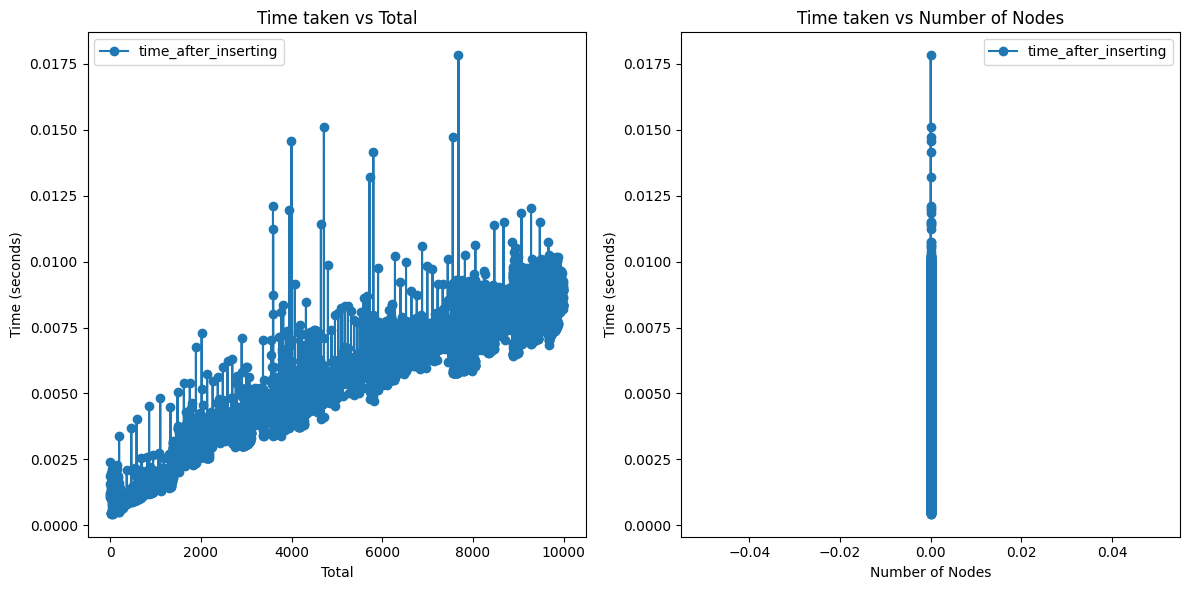

In [33]:
import pandas as pd
import matplotlib.pyplot as plt

time_df = pd.DataFrame(times)

# Assuming time_df is your DataFrame
fig, axs = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns for subplots

# Plot on the first subplot
time_df.plot(ax=axs[0], x="total", y="time_after_inserting", title="Time taken vs Total", marker='o', linestyle='-')
axs[0].set_xlabel("Total")
axs[0].set_ylabel("Time (seconds)")

# Plot on the second subplot
time_df.plot(ax=axs[1], x="num_nodes", y="time_after_inserting", title="Time taken vs Number of Nodes", marker='o', linestyle='-')
axs[1].set_xlabel("Number of Nodes")
axs[1].set_ylabel("Time (seconds)")

plt.tight_layout()  # Adjusts subplot params so that subplots are nicely fit in the figure area.
plt.show()


In [ ]:
pd.DataFrame(scheduler.metrics_dict )

In [ ]:
import json
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

# Load JSON data
file_name = 'metrics_lp_scheduler_2_200.json'
with open(file_name, 'r') as file:
    data = json.load(file)

# Extract overhead values
overhead_values = [entry['overhead'] for entry in data]
max_index = np.argmax(overhead_values)
max_value = overhead_values[max_index]
print("Index with max overhead:", max_index)
print("Value with max overhead:", max_value)

std_dev = np.std(overhead_values) / 4  # Reduced for visualization purposes
error = [std_dev] * len(overhead_values)
# Initial Plot
plt.figure(figsize=(10, 6))
plt.plot(overhead_values, marker='o', linestyle='-', color='b')
plt.title('Overhead over Time for depth = 3')
plt.xlabel('Time (sequential order of metrics)')
plt.ylabel('Overhead (seconds)')
plt.grid(True)
# plt.savefig('initial_overhead_plot.png')
# plt.close()
plt.show()
# More Smoothed Plot
more_smoothed_overhead = savgol_filter(overhead_values, 21, 3)
plt.figure(figsize=(10, 6))
plt.errorbar(range(len(overhead_values)), more_smoothed_overhead, yerr=error, marker='o', linestyle='-', color='g', ecolor='lightgray', elinewidth=3, capsize=0)
plt.title('More Smoothed Overhead over Time with Error Bars')
plt.xlabel('Time (sequential order of metrics)')
plt.ylabel('Overhead (seconds)')
plt.grid(True)
# plt.savefig('more_smoothed_overhead_with_error_bars.png')
# plt.close()
plt.show()



# %%
# Initialize a dictionary to map the first 10 characters to the selected runtime
runtime_selection = {}
correct_predictions = 0
ignore_items = 0
import re

for entry in data:
    text = entry['text']
    matched_tool = re.search(r"You have access of the following tools:\n1.(.+?): ", text)
    if matched_tool:
        tool = matched_tool.group(1)
    first_10_chars = tool
    selected_runtime = entry['selected_runtime']
    # If the first 10 characters have been seen before
    if first_10_chars in runtime_selection:
        # Check if the selected runtime matches the previously recorded runtime
        if runtime_selection[first_10_chars] == selected_runtime:
            correct_predictions += 1
        else:
            print(f"Incorrect prediction for tool: {first_10_chars}")
    else:
        # Record the runtime selection for the first 10 characters
        runtime_selection[first_10_chars] = selected_runtime
        # Assuming the first selection is always correct as there's no precedent
        correct_predictions += 1

# Calculate the accuracy
accuracy_percentage = (correct_predictions / (len(data) - ignore_items)) * 100
accuracy_percentage

In [ ]:
runtime_selection = {}
first_occurrences = set()  # Keep track of tools that have been seen once
correct_predictions = 0
ignore_items = 0
import re

for entry in data:
    text = entry['text']
    matched_tool = re.search(r"You have access of the following tools:\n1.(.+?): ", text)
    if not matched_tool:
        ignore_items += 1
        continue  # If no tool is matched, skip this entry
    
    tool = matched_tool.group(1)[:10]  # Extract first 10 chars of the tool name
    selected_runtime = entry['selected_runtime']
    
    # Check if it's the first occurrence of the tool
    if tool not in first_occurrences and tool not in runtime_selection:
        first_occurrences.add(tool)  # Mark it as seen for the first time
        ignore_items += 1
        continue  # Move to the next entry without doing anything else
    
    # If it's the second time we see the tool, record its runtime
    if tool in first_occurrences and tool not in runtime_selection:
        runtime_selection[tool] = selected_runtime
        ignore_items += 1
        continue  # Move to the next entry after recording the second runtime
    
    # From the third occurrence onwards, we check predictions
    if tool in runtime_selection:
        if runtime_selection[tool] == selected_runtime:
            correct_predictions += 1
        else:
            print(f"Incorrect prediction for tool: {tool}")

print(f"Correct predictions (excluding first occurrences): {correct_predictions}")
accuracy_percentage = (correct_predictions / (len(data) - ignore_items)) * 100
accuracy_percentage

In [ ]:
# from benchmark_workload_gen import LooGLEDataset, LooGLEDatasetType
# dataloader_short = LooGLEDataset(
#     loogle_dataset_type=LooGLEDatasetType.SHORT_QA, 
#     num_patterns=4, 
#     total_num_requests=100, 
#     tokenizer=tokenizer, 
#     load_dist=LoadDistribution.ALL, 
#     crop_max_decode=True)
# workload_short = dataloader_short.generate_workload(max_length=32000)
from benchmark_workload_gen import RandomDataLoader
dataloader = RandomDataLoader(
    num_patterns=100,
    total_num_requests=300,
    tokenizer=tokenizer,
    num_in_context_examples=2,
    output_len=12,
)
workload_random = dataloader.generate_workload(k=1.1)

In [ ]:
scheduler = LPScheduler(3, depth_limit=3, update_interval=1)
runtime_selected = []

# input_ids = [tokenizer.encode(text) for text in texts]
# for i in range(len(texts)):
#     runtime = scheduler.runtime_selector(input_ids=input_ids[i], text=texts[i])
#     scheduler.lp_tree_traversal.pretty_print(scheduler.tree_cache.root_node)
#     runtime_selected.append(runtime)

for i in workload_random:
    runtime = scheduler.runtime_selector(input_ids=i["input_ids"], text=i["text"])
    scheduler.lp_tree_traversal.pretty_print(scheduler.tree_cache.root_node)
    runtime_selected.append(runtime)

In [ ]:
import re
df_random = pd.DataFrame(scheduler.metrics_dict)
def get_tool(x):
    text = x
    
    match = re.search(r"Workload (.+?) Solve", text)
    if match:
        tool = match.group(1)
        return tool
    return text
df_random["text"] = df_random["text"].map(lambda x: get_tool(x))
df_random.to_csv("test_random.csv")

In [ ]:
measure_acc(df_random, num_nodes=3)

AttributeError: 'NoneType' object has no attribute 'x'

Set parameter Username
x 1
y 0
z 1
Obj: 3


<OptimizationStatus.OPTIMAL: 0>

In [37]:
times = []
interval = 20
depth_limit = 5
lp_tree_traversal = LPTreeTraversal(3)
lp_tree_traversal.depth_limit = depth_limit
cache = RadixCache()
random.shuffle(workload)
modified_nodes = set()
for item in workload:
    cache.insert(tuple(item["input_ids"]), modified_nodes=modified_nodes)

for i in range(1000):
    start_time = time.time()
    time_after_inserting = time.time()
    lp_tree_traversal.traverse_and_optimize(cache.root_node, existing_cost=lp_tree_traversal.get_exisiting_cost(), modified_nodes=modified_nodes)
    modified_nodes = set()
    lp_tree_traversal.update_nodes_with_solution()
    # lp_tree_traversal.pretty_print(cache.root_node)
    times.append({"num_nodes": len(lp_tree_traversal.node_map), "time_after_inserting": time.time() - time_after_inserting, "total": (i+1)*interval, "depth_limit": depth_limit})

Set parameter Username
Optimal solution found.
Solving time: 0.004273653030395508s Setup Time 0.001245737075805664s
Optimal solution found.
Solving time: 0.001341104507446289s Setup Time 0.0003807544708251953s
Optimal solution found.
Solving time: 0.0012552738189697266s Setup Time 0.00013136863708496094s
Optimal solution found.
Solving time: 0.0011746883392333984s Setup Time 0.00012373924255371094s
Optimal solution found.
Solving time: 0.0012881755828857422s Setup Time 0.00011301040649414062s
Optimal solution found.
Solving time: 0.0012629032135009766s Setup Time 0.00011396408081054688s
Optimal solution found.
Solving time: 0.0026693344116210938s Setup Time 0.00011301040649414062s
Optimal solution found.
Solving time: 0.002477884292602539s Setup Time 0.00010991096496582031s
Optimal solution found.
Solving time: 0.0012295246124267578s Setup Time 0.00011301040649414062s
Optimal solution found.
Solving time: 0.001207590103149414s Setup Time 0.00011301040649414062s
Optimal solution found.
